> # Load and Prepare the Dataset

In [ ]:
from datasets import load_dataset, DatasetDict

LANGUAGES = ['english', 'spanish', 'hindi', 'french']
MONOLINGUAL_MODEL = 'bert-base-uncased'
MULTILINGUAL_MODEL = 'xlm-roberta-base'
DATASET_NAME = 'cardiffnlp/tweet_sentiment_multilingual'

# Load the dataset for all specified languages
raw_datasets = DatasetDict()
for lang in LANGUAGES:
    # We use trust_remote_code=True as this dataset requires it
    raw_datasets[lang] = load_dataset(
        DATASET_NAME, 
        lang, 
        split='train', 
        trust_remote_code=True
    ).shuffle(seed=42).select(range(1000)) # Using a 1k subset for faster demo
    
print(f"Loaded datasets: {raw_datasets}")

# This dataset already has 0, 1, 2 labels, so no 'map_labels' function is needed!
processed_datasets = raw_datasets

train_splits = []
for lang in LANGUAGES:
    # Split each language's data into train (80%) and test (20%)
    split = processed_datasets[lang].train_test_split(test_size=0.2, seed=42)
    processed_datasets[f'train-{lang}'] = split['train']
    processed_datasets[f'test-{lang}'] = split['test']
    
    # Add to the multilingual training set
    train_splits.append(split['train'])

# Create the combined multilingual training set
from datasets import concatenate_datasets
train_multilingual = concatenate_datasets(train_splits).shuffle(seed=42)

print(f"\nMonolingual Training (English): {processed_datasets['train-english']}")
print(f"Multilingual Training (All): {train_multilingual}")
print(f"\nTest sets created for: {['test-'+lang for lang in LANGUAGES]}")

Loaded datasets: DatasetDict({
    english: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
    spanish: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
    hindi: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
    french: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
})

Monolingual Training (English): Dataset({
    features: ['text', 'label'],
    num_rows: 800
})
Multilingual Training (All): Dataset({
    features: ['text', 'label'],
    num_rows: 3200
})

Test sets created for: ['test-english', 'test-spanish', 'test-hindi', 'test-french']


> # Tokenization and Preprocessing

In [2]:
from transformers import AutoTokenizer

# Load tokenizers
tokenizer_mono = AutoTokenizer.from_pretrained(MONOLINGUAL_MODEL)
tokenizer_multi = AutoTokenizer.from_pretrained(MULTILINGUAL_MODEL)

# Tokenization functions
def tokenize_mono(batch):
    return tokenizer_mono(batch['text'], truncation=True, padding='max_length', max_length=128)

def tokenize_multi(batch):
    return tokenizer_multi(batch['text'], truncation=True, padding='max_length', max_length=128)

# Apply tokenization
# Note: We tokenize all test sets with *both* tokenizers for evaluation
tokenized_train_mono = processed_datasets['train-english'].map(tokenize_mono, batched=True)
tokenized_train_multi = train_multilingual.map(tokenize_multi, batched=True)

# Tokenize all test sets
tokenized_test_sets_mono = {}
tokenized_test_sets_multi = {}

for lang in LANGUAGES:
    key = f'test-{lang}'
    tokenized_test_sets_mono[lang] = processed_datasets[key].map(tokenize_mono, batched=True)
    tokenized_test_sets_multi[lang] = processed_datasets[key].map(tokenize_multi, batched=True)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

> # Evaluation Metrics

In [3]:
import evaluate
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

# Load metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    f1_micro = f1_score(labels, predictions, average='micro')
    f1_macro = f1_score(labels, predictions, average='macro')
    
    return {
        "accuracy": accuracy,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
    }

> # Model 1 - Fine-tune Monolingual BERT

In [4]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Load the model
model_mono = AutoModelForSequenceClassification.from_pretrained(
    MONOLINGUAL_MODEL, 
    num_labels=3
)

training_args_mono = TrainingArguments(
    output_dir="bert-mono-en",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # evaluate=True,
    num_train_epochs=2, # Using 2 epochs for a quick demo
    weight_decay=0.01,
    push_to_hub=False,
)

# Initialize the Trainer
trainer_mono = Trainer(
    model=model_mono,
    args=training_args_mono,
    train_dataset=tokenized_train_mono,
    eval_dataset=tokenized_test_sets_mono['english'], # Evaluate on English test set
    tokenizer=tokenizer_mono,
    compute_metrics=compute_metrics,
)

# --- Train the model ---
print("--- Training Monolingual BERT on English ---")
trainer_mono.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Vatsh Van\AppData\Local\Temp\ipykernel_28608\970652832.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_mono = Trainer(


--- Training Monolingual BERT on English ---


Step,Training Loss


TrainOutput(global_step=100, training_loss=1.0082680511474609, metrics={'train_runtime': 44.5515, 'train_samples_per_second': 35.913, 'train_steps_per_second': 2.245, 'total_flos': 105245367091200.0, 'train_loss': 1.0082680511474609, 'epoch': 2.0})

> # Model 2 - Fine-tune Multilingual XLM-

In [6]:
# Load the model
model_multi = AutoModelForSequenceClassification.from_pretrained(
    MULTILINGUAL_MODEL, 
    num_labels=3
)

training_args_multi = TrainingArguments(
    output_dir="xlm-roberta-multi",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    push_to_hub=False,
)

# Initialize the Trainer
trainer_multi = Trainer(
    model=model_multi,
    args=training_args_multi,
    train_dataset=tokenized_train_multi,
    eval_dataset=tokenized_test_sets_multi['english'], # Evaluate on English test set as a baseline
    tokenizer=tokenizer_multi,
    compute_metrics=compute_metrics,
)

# --- Train the model ---
print("\n--- Training Multilingual XLM-RoBERTa on All Languages ---")
trainer_multi.train()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Vatsh Van\AppData\Local\Temp\ipykernel_28608\228231970.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_multi = Trainer(



--- Training Multilingual XLM-RoBERTa on All Languages ---


Step,Training Loss


TrainOutput(global_step=400, training_loss=0.9727255249023438, metrics={'train_runtime': 2483.7756, 'train_samples_per_second': 2.577, 'train_steps_per_second': 0.161, 'total_flos': 420981468364800.0, 'train_loss': 0.9727255249023438, 'epoch': 2.0})

> # Cross-Lingual Evaluation

In [10]:
import pandas as pd

results = []

# Evaluate Monolingual Model
print("--- Evaluating Monolingual BERT ---")
for lang in LANGUAGES:
    print(f"Evaluating on {lang}...")
    eval_results = trainer_mono.evaluate(tokenized_test_sets_mono[lang])
    eval_results['model'] = 'BERT (Trained EN)'
    eval_results['language'] = lang
    results.append(eval_results)

# Evaluate Multilingual Model
print("\n--- Evaluating Multilingual XLM-R ---")
for lang in LANGUAGES:
    print(f"Evaluating on {lang}...")
    eval_results = trainer_multi.evaluate(tokenized_test_sets_multi[lang])
    eval_results['model'] = 'XLM-R (Trained Multi)'
    eval_results['language'] = lang
    results.append(eval_results)

# Create a DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Clean up and display
results_df = results_df[['model', 'language', 'eval_accuracy', 'eval_f1_macro']]
results_df = results_df.rename(columns={'eval_accuracy': 'Accuracy', 'eval_f1_macro': 'F1 (Macro)'})

print("\n--- Final Results ---")
print(results_df)

--- Evaluating Monolingual BERT ---
Evaluating on english...
Evaluating on spanish...
Evaluating on hindi...
Evaluating on french...

--- Evaluating Multilingual XLM-R ---
Evaluating on english...
Evaluating on spanish...
Evaluating on hindi...
Evaluating on french...

--- Final Results ---
                   model language  Accuracy  F1 (Macro)
0      BERT (Trained EN)  english     0.575    0.517891
1      BERT (Trained EN)  spanish     0.370    0.308452
2      BERT (Trained EN)    hindi     0.295    0.266267
3      BERT (Trained EN)   french     0.415    0.396706
4  XLM-R (Trained Multi)  english     0.650    0.646610
5  XLM-R (Trained Multi)  spanish     0.615    0.605174
6  XLM-R (Trained Multi)    hindi     0.410    0.398788
7  XLM-R (Trained Multi)   french     0.670    0.667771


> # Visualization

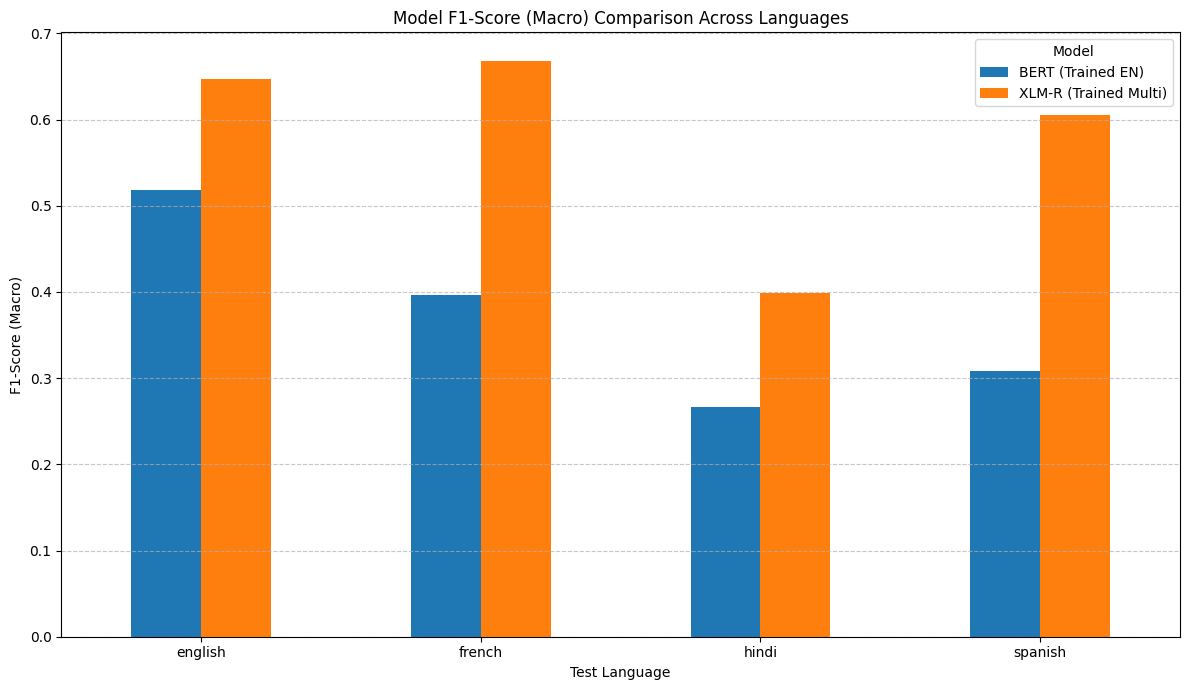

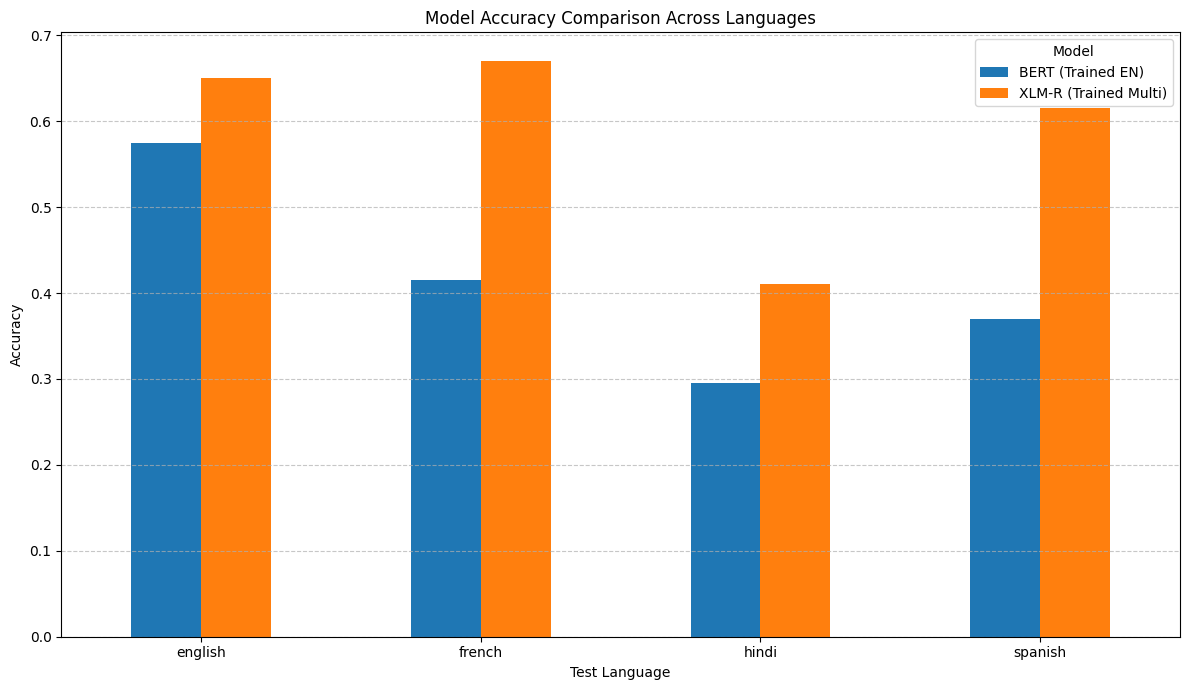

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# --- Plot F1-Score Comparison ---
pivot_df = results_df.pivot(index='language', columns='model', values='F1 (Macro)')

ax = pivot_df.plot(
    kind='bar', 
    figsize=(12, 7), 
    rot=0,
    title='Model F1-Score (Macro) Comparison Across Languages'
)

ax.set_ylabel('F1-Score (Macro)')
ax.set_xlabel('Test Language')
ax.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

# --- Plot Accuracy Comparison ---
pivot_df_acc = results_df.pivot(index='language', columns='model', values='Accuracy')

ax = pivot_df_acc.plot(
    kind='bar', 
    figsize=(12, 7), 
    rot=0,
    title='Model Accuracy Comparison Across Languages'
)

ax.set_ylabel('Accuracy')
ax.set_xlabel('Test Language')
ax.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()